In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from tqdm import tqdm
import json
from time import time
import torch
from natsort import natsorted
# import SimpleITK as sitk

import warnings
warnings.filterwarnings('ignore')

In [3]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms.v2 as transforms
from src.scripts.DataLoaders import ImgForPlot

In [4]:
import pickle
import torch.nn as nn
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

In [5]:
device = 'cuda'

In [6]:
class MyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """ """
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        msk_path = self.mask_paths[index]
        image = self.load_image(img_path, as_mask=False)
        mask = self.load_image(msk_path, as_mask=True)
        
        if self.transform:
            # image, mask = self.transform(image, mask)
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, path, as_mask=False):
        if as_mask:
            img = cv2.imread(path, 0)
            img = np.where(img > 0, 1., 0.)
        else:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255

        img = img.astype(np.float32)

        return img

In [7]:
def get_paths(main_path):
    img_paths = [os.path.join(main_path, "images", img_name) for img_name in os.listdir(os.path.join(main_path, 'images'))]
    msk_paths = [os.path.join(main_path, "masks", img_name) for img_name in os.listdir(os.path.join(main_path, 'masks'))]
    img_paths = natsorted(img_paths)
    msk_paths = natsorted(msk_paths)

    return img_paths, msk_paths

In [8]:
train_path = 'data/train/echoLV/training'
test_path = 'data/train/echoLV/testing'

train_img_paths, train_msk_paths = get_paths(train_path)
test_img_paths, test_msk_paths = get_paths(test_path)

train_img_paths[:5], train_msk_paths[:5]

(['data/train/echoLV/training/images/0X1A0A263B22CCD966_72.jpg',
  'data/train/echoLV/training/images/0X1A0A263B22CCD966_83.jpg',
  'data/train/echoLV/training/images/0X1A2A76BDB5B98BED_63.jpg',
  'data/train/echoLV/training/images/0X1A2A76BDB5B98BED_78.jpg',
  'data/train/echoLV/training/images/0X1A2C60147AF9FDAE_46.jpg'],
 ['data/train/echoLV/training/masks/0X1A0A263B22CCD966_72.png',
  'data/train/echoLV/training/masks/0X1A0A263B22CCD966_83.png',
  'data/train/echoLV/training/masks/0X1A2A76BDB5B98BED_63.png',
  'data/train/echoLV/training/masks/0X1A2A76BDB5B98BED_78.png',
  'data/train/echoLV/training/masks/0X1A2C60147AF9FDAE_46.png'])

In [9]:
assert len(train_img_paths) == len(train_msk_paths)
assert len(test_img_paths) == len(test_msk_paths)
len(train_img_paths)

37035

In [10]:
rand_blur = transforms.RandomApply(torch.nn.ModuleList([
    transforms.GaussianBlur(3),
]), p=0.2)
rand_elastic = transforms.RandomApply(torch.nn.ModuleList([
    transforms.ElasticTransform(alpha=20, sigma=3),
]), p=0.2)

# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    # Color
    # transforms.ColorJitter(),  #
    # transforms.GaussianBlur(5),
    # transforms.RandomInvert(0.7),
    # transforms.RandomAdjustSharpness(0, p=1),
    # transforms.RandomAutocontrast(1),
    # transforms.RandomEqualize(1),
    # rand_blur,
    rand_elastic,
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    transforms.Resize(size=(512, 512)),
    transforms.RandomRotation(5),
    transforms.RandomChannelPermutation(),
    # transforms.ToTensor(),
])

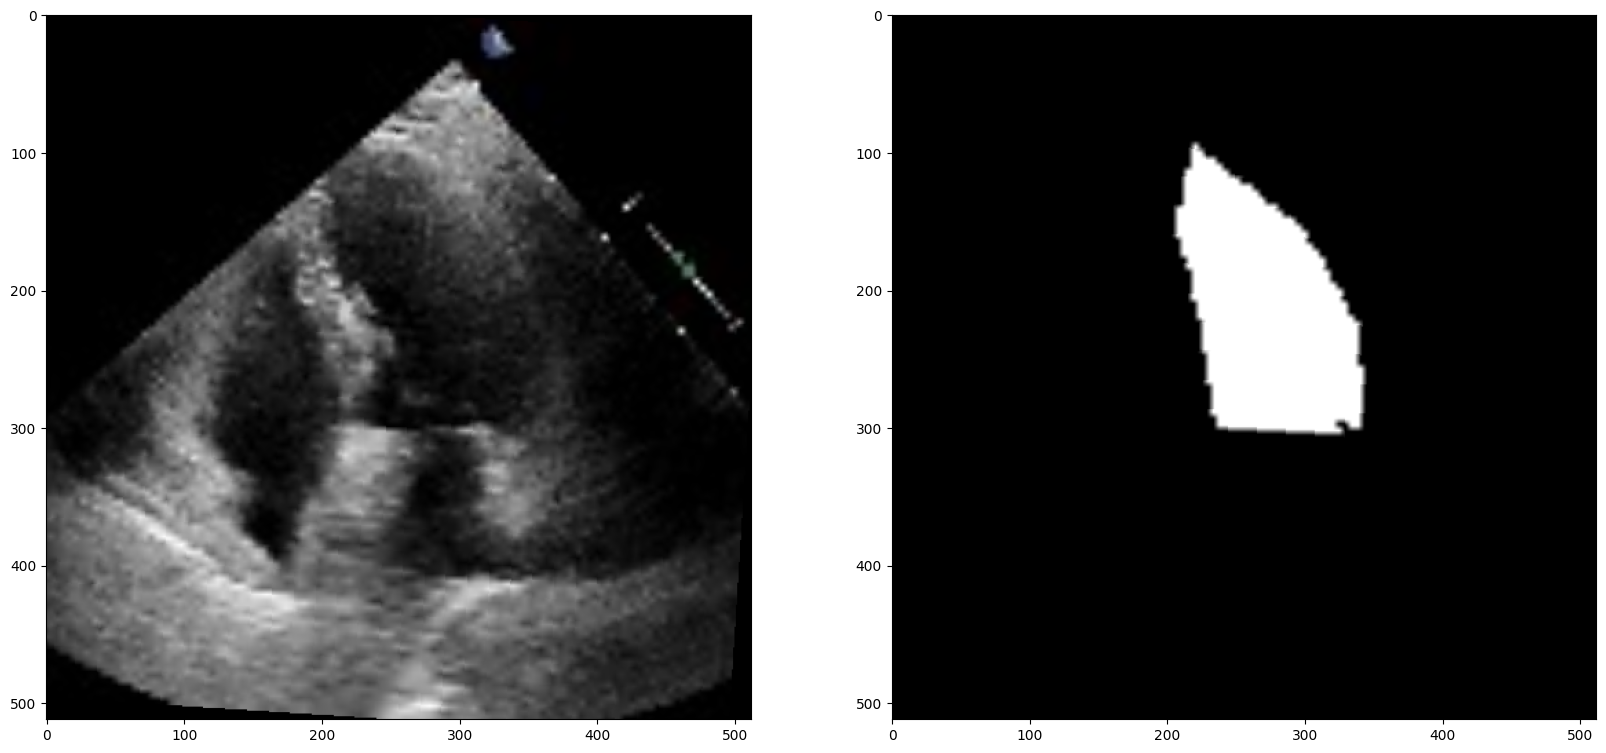

In [11]:
# 
train_dataset = MyDataset(train_img_paths, train_msk_paths, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = MyDataset(test_img_paths, test_msk_paths, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

im, m = next(iter(train_dataset))
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

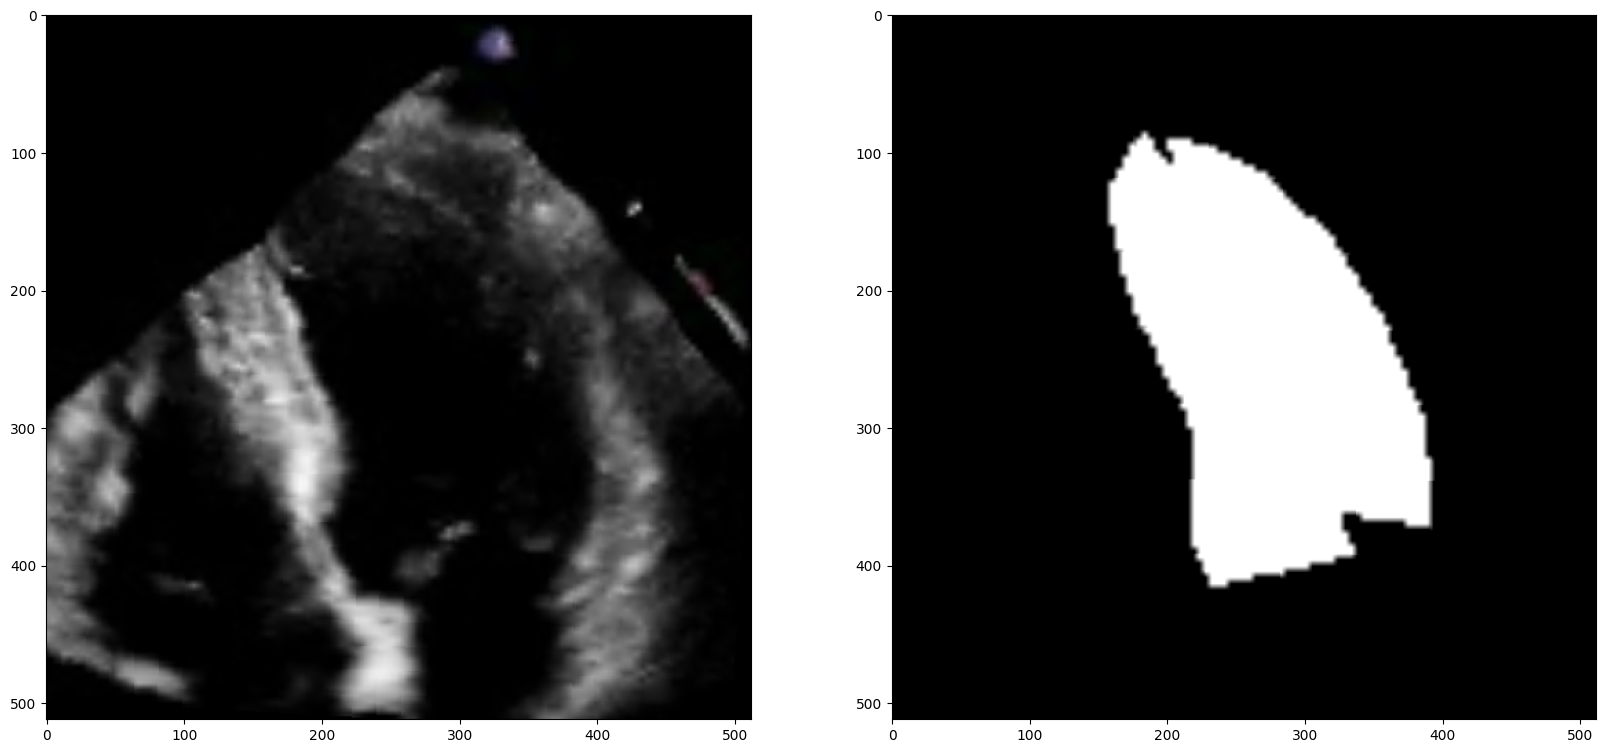

In [12]:
im, m = train_dataset[10]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [13]:
m.shape

torch.Size([1, 512, 512])

In [14]:
m.dtype, im.dtype, m.max(), im.max()

(torch.float32, torch.float32, tensor(1.), tensor(0.9675))

In [15]:
# 
lr = 0.001

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)
model_name = 'u2net-LV'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}_best.pt"
best_model_path = model_path

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

model = U2Net().to(device)
# Continue lerning
# model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

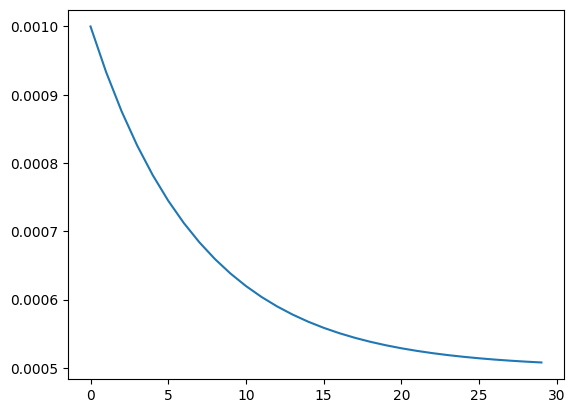

In [16]:
LR_START = 0.001
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0005 # 0.0002
epochs = 30

def ws_lr(epoch, lr):
    return (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW

xx = np.arange(30)

plt.plot(xx, [ws_lr(x, 0.01) for x in xx])

In [17]:
import math


def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [18]:
# BCE = nn.BCELoss(reduction='mean')  # Train
BCE = nn.BCEWithLogitsLoss(reduce='mean')
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

In [ ]:
# Check available GPU memory and total GPU memory 
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

In [19]:
n_print = 500

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        # print(out.max())
        each_loss = [ DBCE(o, target) for o in out ]   # DBCE
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(test_loader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    # torch.save(model.state_dict(), model_path)
    # with open(loss_path, 'wb') as f:
    #     pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.001000
[ 1/30][ 300/18518] Train: 3.2720 (94s)
[ 1/30][ 600/18518] Train: 1.9439 (92s)
[ 1/30][ 900/18518] Train: 1.8200 (91s)
[ 1/30][1200/18518] Train: 1.8165 (92s)
[ 1/30][1500/18518] Train: 1.6734 (88s)
[ 1/30][1800/18518] Train: 1.6162 (82s)
[ 1/30][2100/18518] Train: 1.5441 (82s)
[ 1/30][2400/18518] Train: 1.5362 (82s)
[ 1/30][2700/18518] Train: 1.5824 (82s)
[ 1/30][3000/18518] Train: 1.6242 (82s)
[ 1/30][3300/18518] Train: 1.4952 (82s)
[ 1/30][3600/18518] Train: 1.4773 (82s)
[ 1/30][3900/18518] Train: 1.4335 (82s)
[ 1/30][4200/18518] Train: 1.7311 (82s)
[ 1/30][4500/18518] Train: 1.5642 (82s)
[ 1/30][4800/18518] Train: 1.4110 (82s)
[ 1/30][5100/18518] Train: 1.4693 (82s)
[ 1/30][5400/18518] Train: 1.3530 (81s)
[ 1/30][5700/18518] Train: 1.4517 (82s)
[ 1/30][6000/18518] Train: 1.4292 (82s)
[ 1/30][6300/18518] Train: 1.4826 (82s)
[ 1/30][6600/18518] Train: 1.4616 (82s)
[ 1/30][6900/18518] Train: 1.4503 (82s)
[ 1/30][7200/18518] Train: 1.3846 (84s)
[ 1/30][7500/185

KeyboardInterrupt: 

In [20]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

(512, 512, 1)

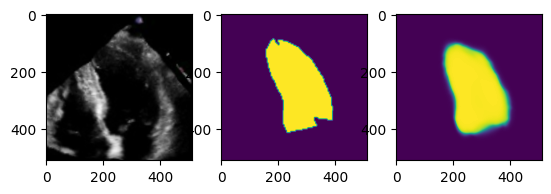

In [22]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
plt.subplot(132)
plt.imshow(ImgForPlot(m));
plt.subplot(133)
plt.imshow(pred)

(944, 1392, 3)


[mjpeg @ 0x57981a86cc00] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x57981a416fc0] unable to decode APP fields: Invalid data found when processing input


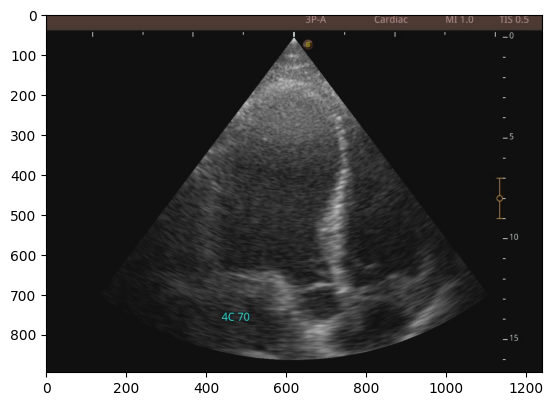

In [23]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read() 
print(frame.shape)
plt.imshow(frame[50:, 150:, :])

torch.Size([1, 3, 512, 512])
(512, 512, 1)


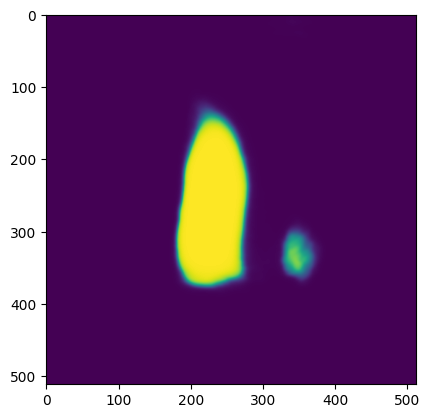

In [24]:
new_img = prepare_input(frame[50:, 150:, :])
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
print(pred.shape)

plt.imshow(pred)